In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import scipy
from sklearn.preprocessing import StandardScaler
from scipy import signal
from scipy import fft
from scipy.fft import fft, ifft, fftfreq
import matplotlib
import matplotlib. pyplot as plt
from sklearn.preprocessing import RobustScaler


In [2]:
df = pd.read_csv('/content/sample.csv')
df

,timestamp,value
0,2023-12-06 15:03:53.908288,1019.0
1,2023-12-06 15:03:53.908288,1019.0
2,2023-12-06 15:03:53.908288,1018.0
3,2023-12-06 15:03:53.908288,775.0
4,2023-12-06 15:03:53.908288,377.0
...,...,...
661681,2023-12-06 16:04:47.436639,183.0
661682,2023-12-06 16:04:47.436639,605.0
661683,2023-12-06 16:04:47.436639,1019.0
661684,2023-12-06 16:04:47.436639,1019.0


In [3]:
df.loc[:750000,'label'] = 0
df.loc[750000:,'label'] = 1

<ipython-input-3-bc141a02e950>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:750000,'label'] = 0


In [4]:
df.isnull().sum()

timestamp    0
value        1
label        0
dtype: int64

In [5]:
df.drop(df.index[150000:310001], inplace=True)
df.reset_index(drop=True, inplace=True)
df.drop(df.index[600000:750000], inplace=True)
#df = df.loc[600000:]
df.reset_index(drop=True, inplace=True)


In [6]:

df.drop(columns=df.columns[0], axis=1, inplace=True)

In [ ]:
df.rename(columns={'value':'raw_eeg'}, inplace=True)
df

,raw_eeg,label
0,1019,0.0
1,1019,0.0
2,1018,0.0
3,775,0.0
4,377,0.0
...,...,...
1195472,5,1.0
1195473,3,1.0
1195474,4,1.0
1195475,641,1.0


In [ ]:
#import matplotlib.pyplot as plt
#
#raw_data = data.values
#
#n = len(raw_data) // 300
#
#notch_freq = 50.0  # for the notch filter
#lowcut, highcut = 0.5, 30.0  # for the bandpass filter
#
##  notch filter
#nyquist = 0.5 * sampling_rate
#notch_freq_normalized = notch_freq / nyquist
#b_notch, a_notch = signal.iirnotch(notch_freq_normalized, Q=0.05, fs=sampling_rate)
#
##  bandpass filter
#lowcut_normalized = lowcut / nyquist
#highcut_normalized = highcut / nyquist
#b_bandpass, a_bandpass = signal.butter(4, [lowcut_normalized, highcut_normalized], btype='band')
#
#order_notch = max(len(b_notch), len(a_notch)) - 1
#order_bandpass = max(len(b_bandpass), len(a_bandpass)) - 1
#
#if len(raw_data) <= max(order_notch, order_bandpass):
#    raise ValueError("The length of the input vector 'raw_data' must be greater than the filter order.")
#
## Apply notch filter
#notch_filtered_data = signal.filtfilt(b_notch, a_notch, raw_data)
#
## Apply bandpass filter
#bandpass_filtered_data = signal.filtfilt(b_bandpass, a_bandpass, raw_data)
#
## Plotting
#plt.figure(figsize=(14, 8))
## Plot your data here...


<Figure size 1400x800 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

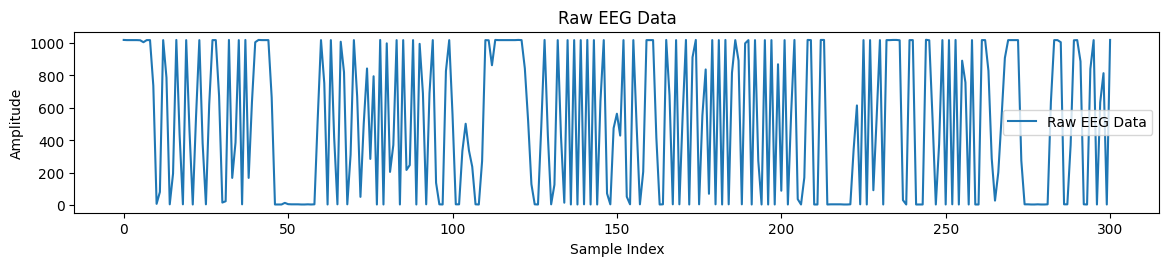

In [ ]:
#plt.figure(figsize=(14, 8))
#plt.subplot(3, 1, 1)
#plt.plot(raw_data[::n], label='Raw EEG Data')
#plt.title('Raw EEG Data')
#plt.xlabel('Sample Index')
#plt.ylabel('Amplitude')
#plt.legend()
#plt.show()

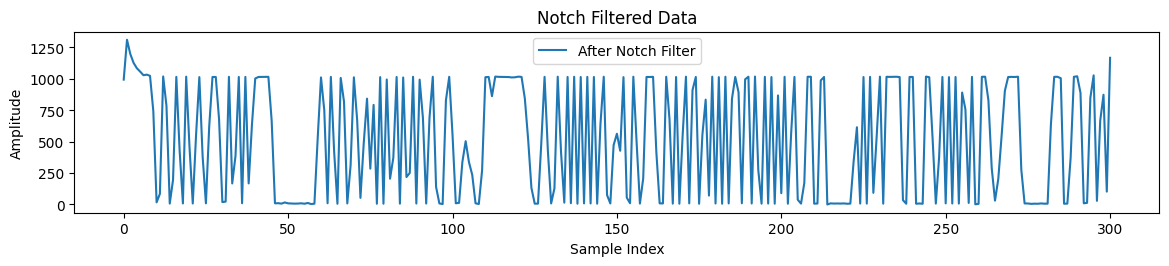

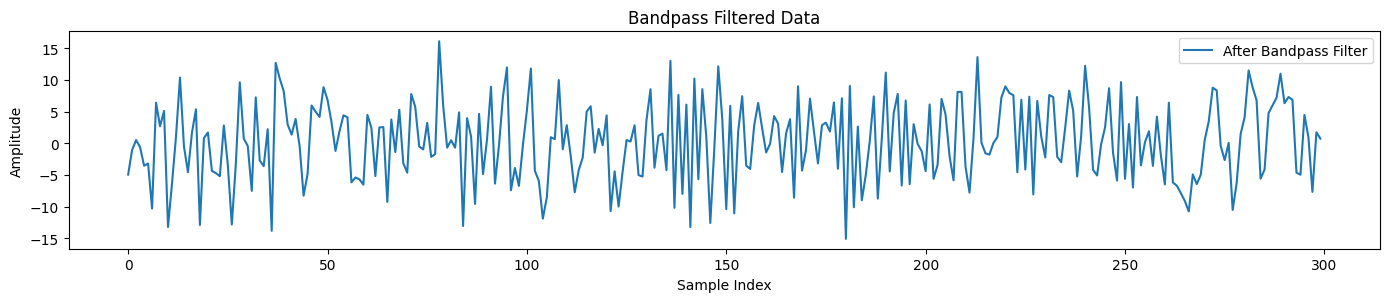

In [ ]:
#plt.figure(figsize=(14, 8))
#
#plt.subplot(3, 1, 2)
#plt.plot(notch_filtered_data[::n], label='After Notch Filter')
#plt.title('Notch Filtered Data')
#plt.xlabel('Sample Index')
#plt.ylabel('Amplitude')
#plt.legend()
#plt.show()
## Plot data after bandpass filter
#plt.figure(figsize=(14, 8))
#
#plt.subplot(3, 1, 3)
#plt.plot(bandpass_filtered_data[2000::n], label='After Bandpass Filter')
#plt.title('Bandpass Filtered Data')
#plt.xlabel('Sample Index')
#plt.ylabel('Amplitude')
#plt.legend()
#
#plt.tight_layout()
#plt.show()

In [ ]:
data = df['raw_eeg']
labels_old = df['label']



sampling_rate = 512

notch_freq = 50.0  # for the notch filter
lowcut, highcut = 0.5, 30.0  # for the bandpass filter

#  notch filter
nyquist = (0.5 * sampling_rate)
notch_freq_normalized = notch_freq / nyquist
b_notch, a_notch = signal.iirnotch(notch_freq_normalized, Q=0.05, fs=sampling_rate)

#  bandpass filter
lowcut_normalized = lowcut / nyquist
highcut_normalized = highcut / nyquist
b_bandpass, a_bandpass = signal.butter(4, [lowcut_normalized, highcut_normalized], btype='band')

features = []
labels = []
additional_features_list = []

def calculate_psd_features(segment, sampling_rate):
    f, psd_values = scipy.signal.welch(segment, fs=sampling_rate, nperseg=len(segment))

    alpha_indices = np.where((f >= 8) & (f <= 13))
    beta_indices = np.where((f >= 14) & (f <= 30))
    theta_indices = np.where((f >= 4) & (f <= 7))
    delta_indices = np.where((f >= 0.5) & (f <= 3))

    energy_alpha = np.sum(psd_values[alpha_indices])
    energy_beta = np.sum(psd_values[beta_indices])
    energy_theta = np.sum(psd_values[theta_indices])
    energy_delta = np.sum(psd_values[delta_indices])

    # Calculate the alpha-beta ratio feature
    alpha_beta_ratio = energy_alpha / energy_beta

    return {
        'E_alpha': energy_alpha,
        'E_beta': energy_beta,
        'E_theta': energy_theta,
        'E_delta': energy_delta,
        'alpha_beta_ratio': alpha_beta_ratio
    }

def calculate_additional_features(segment, sampling_rate):
    f, psd = scipy.signal.welch(segment, fs=sampling_rate, nperseg=len(segment))

    # Peak frequency
    peak_frequency = f[np.argmax(psd)]

    # Spectral centroid
    spectral_centroid = np.sum(f * psd) / np.sum(psd)

    # Spectral slope
    log_f = np.log(f[1:])
    log_psd = np.log(psd[1:])
    spectral_slope = np.polyfit(log_f, log_psd, 1)[0]

    return {
        'peak_frequency': peak_frequency,
        'spectral_centroid': spectral_centroid,
        'spectral_slope': spectral_slope
    }


for i in range(0, len(data) - 512, 256):
    segment = data.loc[i:i+512]
    segment = pd.to_numeric(segment, errors='coerce')

    #  notch filter
    segment = signal.filtfilt(b_notch, a_notch, segment)

    #  bandpass filter
    segment = signal.filtfilt(b_bandpass, a_bandpass, segment)


    segment_features = calculate_psd_features(segment,512)
    additional_features = calculate_additional_features(segment, 512)

    segment_features = {**segment_features, **additional_features}

    features.append(segment_features)
    labels.append(labels_old[i])

X = np.array(features)
y = np.array(labels)

In [ ]:
#features
segment_features

{'E_alpha': 2.0653845805798374,
 'E_beta': 2.458197274299894,
 'E_theta': 1.3326846780942416,
 'E_delta': 4183.224567304233,
 'alpha_beta_ratio': 0.8402029414698088,
 'peak_frequency': 0.9980506822612085,
 'spectral_centroid': 1.197523251410734,
 'spectral_slope': -8.1499096692891}

In [ ]:
columns = ['E_alpha', 'E_beta', 'E_theta', 'E_delta', 'alpha_beta_ratio','peak_frequency','spectral_centroid','spectral_slope']

# Create a DataFrame
df = pd.DataFrame(features, columns=columns)

df['label'] = y


In [ ]:
df.describe()

,E_alpha,E_beta,E_theta,E_delta,alpha_beta_ratio,peak_frequency,spectral_centroid,spectral_slope,label
count,4668.000000,4668.000000,4668.000000,4668.000000,4668.000000,4668.000000,4668.000000,4668.000000,4668.000000
mean,1.993779,3.639141,3.302659,8547.679668,0.704298,0.986719,1.141210,-7.949562,0.506213
std,6.974647,25.940239,4.555435,5268.405894,0.635397,0.107752,0.926478,0.304361,0.500015
min,0.092554,0.627167,0.214029,85.100676,0.038051,0.000000,0.730356,-10.736762,0.000000
25%,0.843825,1.988620,1.600939,3873.514878,0.326536,0.998051,0.802718,-8.073972,0.000000
50%,1.358291,2.559099,2.187858,8116.009120,0.535417,0.998051,0.817561,-7.853230,1.000000
75%,2.221982,3.292094,3.254712,13465.623188,0.873457,0.998051,1.015807,-7.736258,1.000000
max,321.475105,1250.395245,88.587947,17967.602255,15.502736,1.996101,11.793181,-7.449424,1.000000


In [ ]:
scaler = StandardScaler()
#scaler = RobustScaler()
X_scaled = scaler.fit_transform(df.drop('label', axis=1))
df_scaled = pd.DataFrame(X_scaled, columns=columns)

# Add labels to the DataFrame
df_scaled['label'] = df['label']

In [ ]:
#df_scaled
X_scaled

array([[-0.05319949,  0.06420891,  0.80785813, ...,  0.10517633,
        -0.40222424, -0.16575333],
       [-0.08117028,  0.11974823,  0.00537162, ...,  0.10517633,
        -0.40201426,  0.25641321],
       [ 0.07123162,  0.21734519, -0.05429988, ...,  0.10517633,
        -0.40138028, -0.50358229],
       ...,
       [-0.14800599, -0.10502478, -0.50206131, ...,  0.10517633,
        -0.33836407, -0.10759174],
       [-0.00561057, -0.00207587, -0.44414351, ...,  0.10517633,
        -0.18126319, -1.79614577],
       [ 0.01026759, -0.04553041, -0.43249108, ...,  0.10517633,
         0.06078894, -0.65832815]])

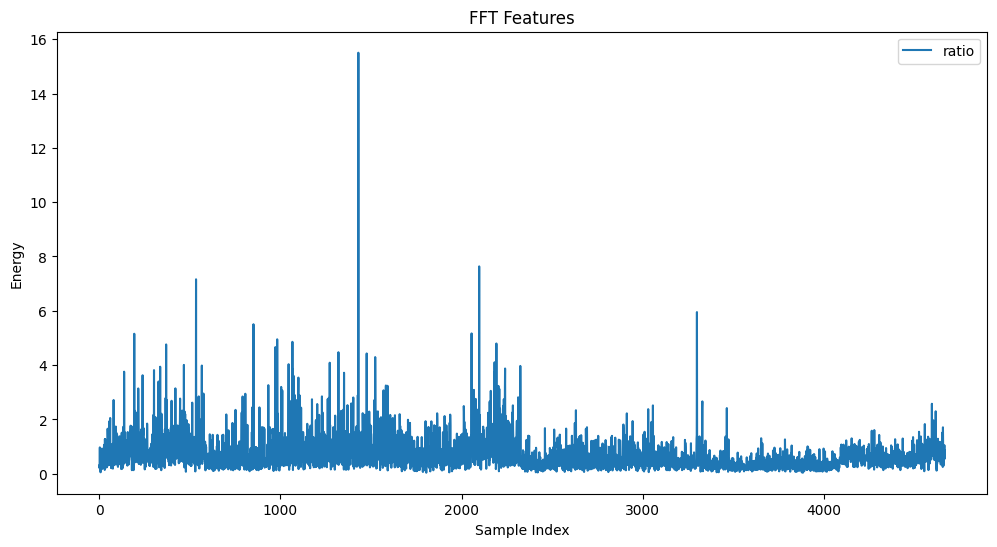

In [ ]:
import matplotlib.pyplot as plt



# Plot FFT features
plt.figure(figsize=(12, 6))
#plt.plot(df.index, df['E_alpha'], label='Alpha Energy')
#plt.plot(df.index, df['E_beta'], label='Beta Energy')
###plt.plot(df.index, df['E_theta'], label='theta Energy')
#plt.plot(df.index, df['E_delta'], label='delta Energy')

plt.plot(df.index, df['alpha_beta_ratio'], label='ratio')

plt.xlabel('Sample Index')
plt.ylabel('Energy')
plt.title('FFT Features')
plt.legend()
plt.show()




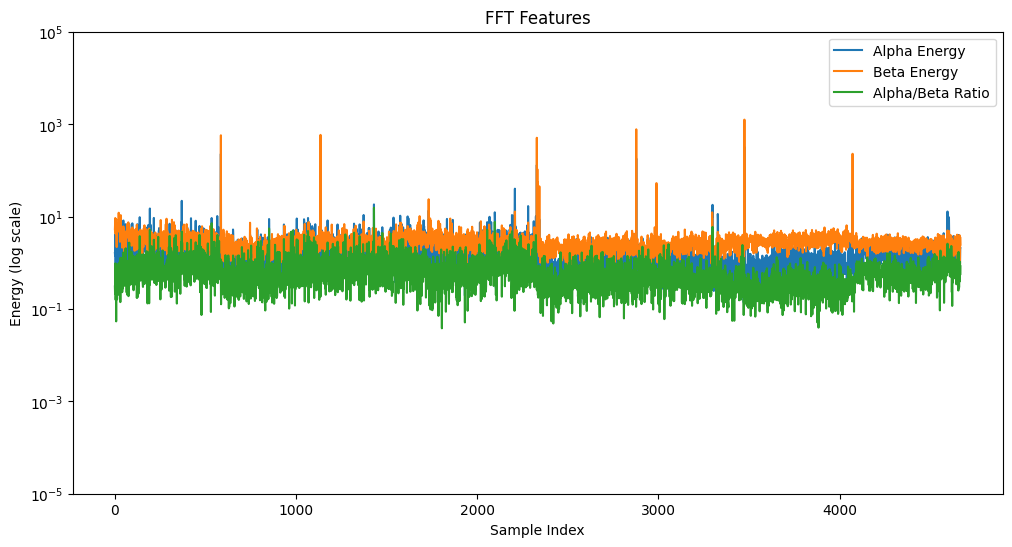

In [ ]:
import matplotlib.pyplot as plt

# Plot FFT features
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['E_alpha'], label='Alpha Energy')
plt.plot(df.index, df['E_beta'], label='Beta Energy')
#plt.plot(df.index, df['E_theta'], label='Theta Energy')
#plt.plot(df.index, df['E_delta'], label='Delta Energy')
plt.plot(df.index, df['alpha_beta_ratio'], label='Alpha/Beta Ratio')

plt.yscale('log')

threshold = 1e5
plt.ylim([1e-5, threshold])

plt.xlabel('Sample Index')
plt.ylabel('Energy (log scale)')
plt.title('FFT Features')
plt.legend()
plt.show()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_scaled.drop('label', axis=1), df_scaled['label'], test_size=0.2, random_state=42)

#clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf = SVC(probability=True, random_state=42)


clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Classification Accuracy: {accuracy}")

Classification Accuracy: 0.7612419700214133


In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

X = df_scaled.drop('label', axis=1)
y = df_scaled['label']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'C': [0.1, 1, 10, 100],  
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001, 0.0001],  
    'kernel': ['rbf']  
}

svc = SVC(probability=True)

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Evaluating the model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = best_model.score(X_test, y_test)
print("Test set accuracy: {:.2f}".format(test_accuracy))


In [ ]:
X_test

,E_alpha,E_beta,E_theta,E_delta,alpha_beta_ratio,peak_frequency,spectral_centroid,spectral_slope
2776,-0.161249,-0.022700,-0.116425,1.408044,-0.660023,0.105176,-0.353448,0.906931
1634,0.210401,0.036118,1.429333,-1.146497,0.081953,0.105176,0.128871,-2.007365
1074,0.734453,-0.023586,2.817966,1.309155,2.591068,0.105176,-0.359794,-0.004152
2080,0.139518,-0.070247,-0.366940,-0.412860,1.461255,0.105176,-0.382424,-0.104313
4060,-0.048318,-0.019315,1.214681,-0.746880,-0.277559,0.105176,-0.312207,0.403665
...,...,...,...,...,...,...,...,...
2856,0.004735,-0.022113,-0.125073,0.400819,-0.067919,0.105176,-0.390636,0.133987
4236,-0.123524,-0.064038,0.220643,-0.280612,-0.207572,0.105176,-0.407397,0.013131
831,-0.126751,-0.021584,-0.546766,-1.093148,-0.541269,0.105176,0.131801,-1.178468
4099,-0.045711,-0.023126,0.274676,-0.518271,-0.241113,0.105176,-0.348739,-0.596803


In [ ]:
import pickle

model_filename = 'best_svm_model.pkl'  

with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

['svm_modeldec7.joblib']

In [ ]:
import pickle

scaler_filename = 'best_scaler.pkl'  

with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)

['scaler7.joblib']

In [ ]:
probabilities = best_model.predict_proba(X_test)[:,1]
print(f"Class Probabilities: {probabilities}")

Class Probabilities: [0.89485755 0.04504349 0.13902825 0.06793108 0.12905387 0.42945208
 0.24102129 0.51440657 0.06833215 0.47638499 0.84054982 0.78133372
 0.37745686 0.71125837 0.89168803 0.90141733 0.91984535 0.56875286
 0.05800492 0.69155402 0.94590817 0.63327843 0.79496596 0.18173499
 0.90542918 0.88432702 0.9686099  0.54136072 0.64441982 0.82910552
 0.07826303 0.63433853 0.78031967 0.82034244 0.20775352 0.14630374
 0.56479534 0.4666719  0.72094284 0.38620008 0.92955719 0.70617276
 0.3385661  0.26304335 0.13629038 0.67784813 0.02123747 0.85348271
 0.04989814 0.16258781 0.0382607  0.21627391 0.5        0.85311408
 0.79535698 0.73715054 0.69636224 0.2303319  0.06536458 0.65992254
 0.9319627  0.57376201 0.35675864 0.05918655 0.07093678 0.48375133
 0.46588896 0.6936983  0.81533153 0.33539894 0.35554585 0.29067342
 0.75325956 0.90619789 0.18154107 0.94805828 0.08185421 0.16215329
 0.51666916 0.71638346 0.93938649 0.66049344 0.64465286 0.41671068
 0.58263408 0.4557183  0.21550069 0.46670

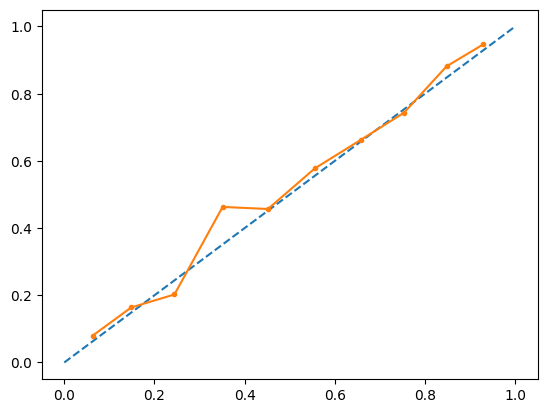

In [ ]:
from sklearn.calibration import calibration_curve
fop, mpv = calibration_curve(y_test, probabilities, n_bins=10)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(mpv, fop, marker='.')
plt.show()

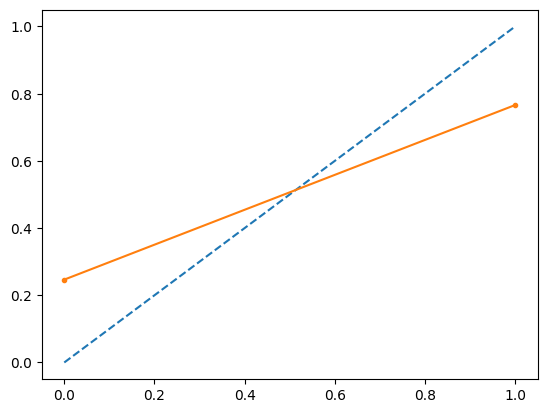

Classification Accuracy: 0.7601713062098501


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

y_true = df_scaled['label']
y_pred = best_model.predict(X_scaled)

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Precision
precision = precision_score(y_true, y_pred)
print(f'Precision: {precision:.4f}')

# Recall
recall = recall_score(y_true, y_pred)
print(f'Recall: {recall:.4f}')

# F1 Score
f1 = f1_score(y_true, y_pred)
print(f'F1 Score: {f1:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Classification Report
class_report = classification_report(y_true, y_pred)
print('Classification Report:')
print(class_report)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Accuracy: 0.7770
Precision: 0.7584
Recall: 0.8210
F1 Score: 0.7885
Confusion Matrix:
[[1687  618]
 [ 423 1940]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.73      0.76      2305
         1.0       0.76      0.82      0.79      2363

    accuracy                           0.78      4668
   macro avg       0.78      0.78      0.78      4668
weighted avg       0.78      0.78      0.78      4668

